# Post-Processing (General)

#### Updated: May 17, 2023

#  

Post-processing pipeline after stage 2 of Alouette processing (OCR processing stage):

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns

In [2]:
rootDir = 'L:/DATA/Alouette_I/BATCH_I_Run2/'
processedDir = rootDir + '04_processed/'
resultDir = rootDir + '05_result/'
logDir = rootDir + '06_log/'

#  

#### Functions:

In [3]:
def construct_timestamp(df_in):
    
    df_in['time_quality'] = 0
    
    #To the nearest second (time quality 1)
    df_in['month_day'] = pd.to_datetime(df_in['day_of_year'], format='%j').dt.strftime('%m-%d')
    df_in['month'] = df_in['month_day'].str.split('-').str[0]
    df_in['day'] = df_in['month_day'].str.split('-').str[1]
    df_in['Timestamp'] = pd.to_datetime(df_in[['year', 'month', 'day', 'hour', 'minute', 'second']], format='%Y-%m-%d %H:%M:%S')
    df_in.loc[~df_in['Timestamp'].isnull(), 'time_quality'] = 1
    df_in_tq1 = df_in.loc[df_in['time_quality'] == 1]
    
    #To the nearest minute (time quality 2)
    df_in_not_tq1 = df_in.loc[df_in['time_quality'] != 1]
    df_in_not_tq1 = df_in_not_tq1.copy(deep=True)
    df_in_not_tq1['Timestamp'] = pd.to_datetime(df_in_not_tq1[['year', 'month', 'day', 'hour', 'minute']], format='%Y-%m-%d %H:%M:00')
    df_in_not_tq1.loc[~df_in_not_tq1['Timestamp'].isnull(), 'time_quality'] = 2
    df_in_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] == 2]
    
    #To the nearest hour (time quality 3)
    df_in_not_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] != 2]
    df_in_not_tq2 = df_in_not_tq2.copy(deep=True)
    df_in_not_tq2['Timestamp'] = pd.to_datetime(df_in_not_tq2[['year', 'month', 'day', 'hour']], format='%Y-%m-%d %H:00:00')
    df_in_not_tq2.loc[~df_in_not_tq2['Timestamp'].isnull(), 'time_quality'] = 3
    df_in_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] == 3]
    
    #To the nearest day (time quality 4)
    df_in_not_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] != 3]
    df_in_not_tq3 = df_in_not_tq3.copy(deep=True)
    df_in_not_tq3['Timestamp'] = pd.to_datetime(df_in_not_tq3[['year', 'month', 'day']], format='%Y-%m-%d 00:00:00')
    df_in_not_tq3.loc[~df_in_not_tq3['Timestamp'].isnull(), 'time_quality'] = 4
    df_in_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] == 4]
    
    df_in_not_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] != 4]
    df_in = pd.concat([df_in_tq1, df_in_tq2, df_in_tq3, df_in_tq4, df_in_not_tq4])
    
    return df_in

#  

#### Generate processed_inventory, concatenate stage 1 results - RUN BEFORE starting stage 2 processing (OCR processing stage):

Generate processed_inventory:

In [ ]:
df_inventory = pd.DataFrame()
for directory in os.listdir(processedDir):
    print(directory)
    for subdirectory in os.listdir(processedDir + directory):
        n_images = len(os.listdir(processedDir + directory + '/' + subdirectory))
        df_inventory_ = pd.DataFrame({
            'Directory': directory, 
            'Subdirectory': subdirectory,
            'images': n_images,
            'subdir_id': directory + '_' + subdirectory
        }, index=[0])
        df_inventory = pd.concat([df_inventory, df_inventory_], axis=0, ignore_index=True)

In [ ]:
print(len(df_inventory))
df_inventory.head()

In [ ]:
df_inventory.to_csv(logDir + 'image_inventory_processed.csv', index=False)

Concatenate stage 1 results:

In [ ]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result-' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[1].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_stage1_raw.csv', low_memory=False)
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                    df_load = pd.DataFrame()
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_stage1_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_stage1_raw.csv', index=False)

In [ ]:
df_result = pd.read_csv(resultDir + 'result_stage1_raw.csv')
print(len(df_result))
df_result.sample(10)

#  

#### Concatenate 'OCR pass' results - START HERE after stage 2 processeing (OCR processing stage):

In [4]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result_OCRpass' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[2].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_stage2_raw.csv', low_memory=False)
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_stage2_raw.csv', index=False)

Now saving the 100th result...
30492
Now saving the 200th result...
60558
Now saving the 300th result...
90849
Now saving the 400th result...
120984
Now saving the 500th result...
150296
Now saving the 600th result...
182952
Now saving the 700th result...
221440
Now saving the 800th result...
258415
Now saving the 900th result...
294533
Now saving the 1000th result...
330737
Now saving the 1100th result...
362695
Now saving the 1200th result...
394575
Now saving the 1300th result...
425278
Now saving the 1400th result...
457247
Now saving the 1500th result...
488785
Now saving the 1600th result...
520876
Now saving the 1700th result...
553371
Now saving the 1800th result...
585860
Now saving the 1900th result...
618748
Now saving the 2000th result...
651887
Now saving the 2100th result...
685839
Now saving the 2200th result...
719947
Now saving the 2300th result...
753545
Now saving the 2400th result...
789989
Now saving the 2500th result...
828626


#  

#### Reduce columns:

In [5]:
df_result = pd.read_csv(resultDir + 'result_stage2_raw.csv', low_memory=False)
print(len(df_result))
df_result.head()

840652


,fmin,max_depth,satellite_number,year,day_1,day_2,day_3,hour_1,hour_2,minute_1,...,filename,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR,station_code,station_number,rotated_metadata
0,1.5,387.500000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,10.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.5,504.166667,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,100.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.5,556.250000,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,101.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.5,654.166667,0.0,0.0,1.0,0.0,1.0,2.0,0.0,2.0,...,102.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.5,556.250000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,103.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_result['year_1'] = df_result['year']
df_result = df_result[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 
                       'station_number', 'station_number_1', 'station_number_2', 'year_1', 'day_1', 'day_2', 'day_3', 
                       'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'satellite_number', 
                       'station_number_OCR', 'year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR', 
                       'metadata_type', 'is_dot', 'func_name', 'details']] 
df_result.sample(10)

,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR,metadata_type,is_dot,func_name,details
249622,R014207929F,467,Image0211.png,num,1.504032,1900.000000,NaN,0.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61491,R014207823,3578-19A,54.png,loss,1.500000,1347.916667,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
828703,R014207980,1023-A,171.png,num,2.064516,1394.117647,NaN,0.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
660245,R014207965,1643-18B,265.png,num,1.693548,1096.153846,NaN,1.0,8.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
469224,R014207951,2460-8A,24.png,num,1.758065,1284.615385,NaN,0.0,8.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
325608,R014207940F,371,Image0221.png,loss,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,bottom,NaN,NaN,NaN
789641,R014207978F,307,Image0272.png,loss,1.536290,968.292683,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata was interpreted to be dot type
447949,R014207949,2151-5B,253.png,num,1.717742,1431.481481,NaN,0.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
389830,R014207946,1838-1B,55.png,num,1.697581,1223.214286,NaN,0.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
514452,R014207955,2845-50B,5.png,loss,1.677419,1263.829787,NaN,NaN,NaN,NaN,...,50.0,65.0,2aa,05,ab,17,NaN,NaN,NaN,OCR read metadata contains letters


#  

#### Split results into different metadata types (dot, num, num2):

In [7]:
df_result['processed_image_class'].unique()

array(['num', 'loss', 'outlier', 'num2', 'dot'], dtype=object)

In [8]:
df_num2 = df_result.loc[df_result['processed_image_class'] == 'num2']
print(len(df_num2))

40699


In [9]:
df_num = df_result.loc[df_result['processed_image_class'] == 'num']
print(len(df_num))

561252


In [10]:
df_dot = df_result.loc[df_result['processed_image_class'] == 'dot']
print(len(df_dot))

66282


In [11]:
df_outlier = df_result.loc[df_result['processed_image_class'] == 'outlier']
print(len(df_outlier))

28394


In [12]:
df_loss = df_result.loc[df_result['processed_image_class'] == 'loss']
print(len(df_loss))

144025


In [13]:
len(df_num2) + len(df_num) + len(df_dot) + len(df_outlier) + len(df_loss)

840652

#### num2 - check timestamp components, construct timestamp:

In [14]:
df_num2[['year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR']].sample(10)

,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
128220,65.0,249,18,37,23
130757,65.0,268.0,03,31,06
42427,65.0,226.0,18,19,18
131826,65.0,280,13,22,56
106620,65.0,329.0,19,52,58
84735,65.0,284.0,04,19.0,30
22433,66.0,003,15.0,51.0,26
150993,65,046,24,12,45
124165,65.0,216.0,22,48,41
85732,65.0,292.0,16,2.0,18


year:

<Axes: xlabel='year_OCR', ylabel='Count'>

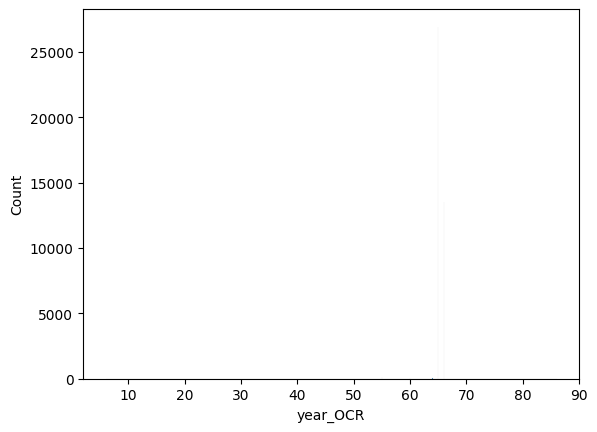

In [15]:
df_num2 = df_num2.copy(deep=True)
df_num2['year_OCR'] = df_num2['year_OCR'].astype('float')
sns.histplot(data=df_num2, x='year_OCR')

In [16]:
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x<62 else x)
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x>80 else x)

In [17]:
df_num2['year'] = df_num2['year_OCR'] + 1900
df_num2[['year', 'year_OCR']].sample(10)

,year,year_OCR
121022,1965.0,65.0
50035,1965.0,65.0
155287,1965.0,65.0
26534,1966.0,66.0
79346,1965.0,65.0
129587,1965.0,65.0
110675,1965.0,65.0
145504,1965.0,65.0
49809,1965.0,65.0
27387,1966.0,66.0


day:

<Axes: xlabel='day_of_year_OCR', ylabel='Count'>

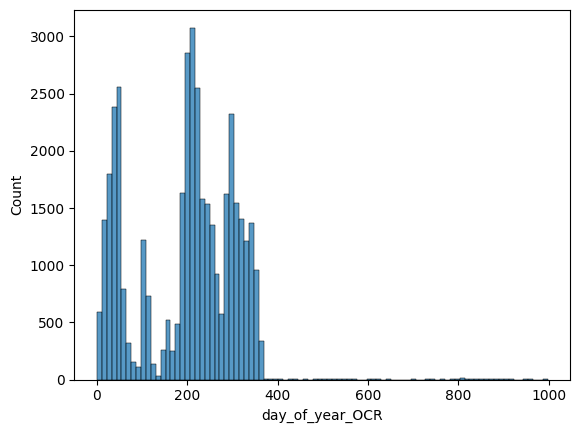

In [18]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].astype('float')
sns.histplot(data=df_num2, x='day_of_year_OCR')

In [19]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x>366 else x)
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x==0 else x)
df_num2['day_of_year'] = df_num2['day_of_year_OCR']
df_num2[['day_of_year', 'day_of_year_OCR']].sample(10)

,day_of_year,day_of_year_OCR
41993,219.0,219.0
30401,52.0,52.0
143228,31.0,31.0
19735,41.0,41.0
51644,350.0,350.0
51088,330.0,330.0
25071,41.0,41.0
28568,41.0,41.0
70179,330.0,330.0
133209,288.0,288.0


hour:

<Axes: xlabel='hour_OCR', ylabel='Count'>

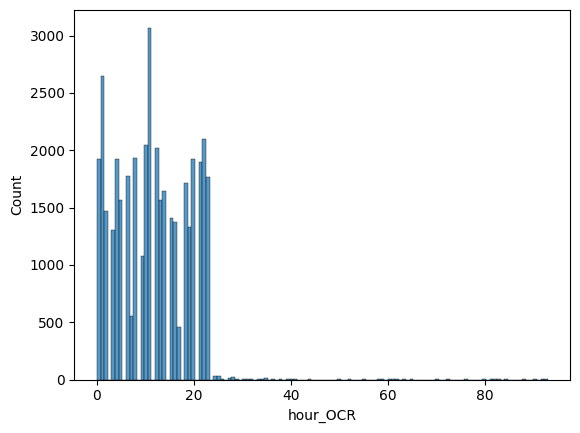

In [20]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].astype('float')
sns.histplot(data=df_num2, x='hour_OCR')

In [21]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].apply(lambda x: np.nan if x>24 else x)
df_num2['hour'] = df_num2['hour_OCR']
df_num2[['hour', 'hour_OCR']].sample(10)

,hour,hour_OCR
17576,13.0,13.0
144406,15.0,15.0
102607,18.0,18.0
56189,14.0,14.0
135612,11.0,11.0
101850,12.0,12.0
150645,8.0,8.0
49987,22.0,22.0
524973,7.0,7.0
145606,19.0,19.0


minute:

<Axes: xlabel='minute_OCR', ylabel='Count'>

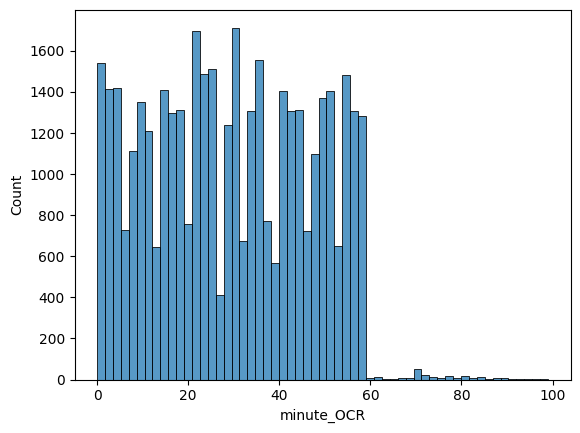

In [22]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].astype('float')
sns.histplot(data=df_num2, x='minute_OCR')

In [23]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['minute'] = df_num2['minute_OCR']
df_num2[['minute', 'minute_OCR']].sample(10)

,minute,minute_OCR
150174,6.0,6.0
142598,24.0,24.0
19657,16.0,16.0
44884,50.0,50.0
18443,42.0,42.0
133112,30.0,30.0
25329,13.0,13.0
65391,56.0,56.0
25580,2.0,2.0
150605,16.0,16.0


second:

<Axes: xlabel='second_OCR', ylabel='Count'>

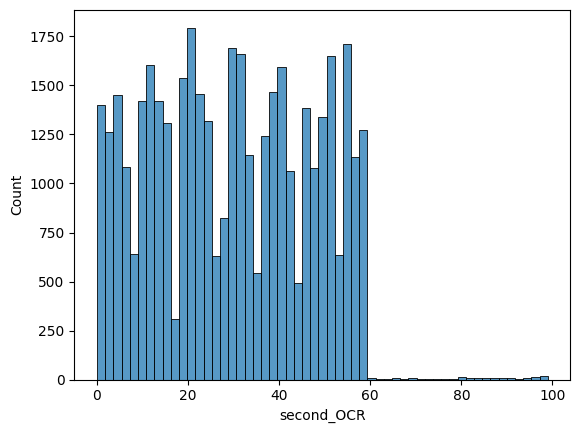

In [24]:
df_num2['second_OCR'] = df_num2['second_OCR'].astype('float')
sns.histplot(data=df_num2, x='second_OCR')

In [25]:
df_num2['second_OCR'] = df_num2['second_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['second'] = df_num2['second_OCR']
df_num2[['second', 'second_OCR']].sample(10)

,second,second_OCR
54324,14.0,14.0
42357,36.0,36.0
109815,19.0,19.0
131354,15.0,15.0
17410,31.0,31.0
30113,7.0,7.0
127397,22.0,22.0
141844,30.0,30.0
51776,55.0,55.0
39112,24.0,24.0


construct timestamp:

In [26]:
df_num2 = construct_timestamp(df_in=df_num2)
print(len(df_num2))

40699


In [27]:
df_num2[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
37605,1965.0,09,05,16.0,40.0,41.0,1965-09-05 16:40:41,1
19616,1966.0,02,13,10.0,28.0,22.0,1966-02-13 10:28:22,1
70901,1965.0,12,11,18.0,3.0,4.0,1965-12-11 18:03:04,1
521832,1965.0,07,11,4.0,52.0,37.0,1965-07-11 04:52:37,1
138190,1965.0,11,25,8.0,34.0,48.0,1965-11-25 08:34:48,1
34426,1966.0,01,14,5.0,31.0,51.0,1966-01-14 05:31:51,1
134847,1965.0,10,28,12.0,21.0,55.0,1965-10-28 12:21:55,1
141974,1966.0,02,04,4.0,33.0,45.0,1966-02-04 04:33:45,1
46670,1965.0,09,28,13.0,7.0,3.0,1965-09-28 13:07:03,1
32518,1966.0,04,16,16.0,34.0,39.0,1966-04-16 16:34:39,1


#  

#### num - check timestamp components, construct timestamp:

In [28]:
df_num[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2
725646,4.0,0.0,1.0,4.0,2.0,2.0,5.0,3.0,3.0,6.0
229351,1.0,1.0,0.0,1.0,0.0,6.0,1.0,0.0,2.0,8.0
544425,5.0,1.0,1.0,5.0,1.0,6.0,4.0,8.0,2.0,5.0
234483,3.0,0.0,3.0,9.0,0.0,9.0,3.0,9.0,2.0,5.0
418541,4.0,1.0,6.0,1.0,0.0,5.0,4.0,0.0,2.0,0.0
115165,1.0,0.0,4.0,3.0,1.0,4.0,0.0,3.0,4.0,2.0
301658,3.0,1.0,9.0,0.0,0.0,9.0,4.0,3.0,0.0,7.0
713409,3.0,3.0,8.0,5.0,0.0,7.0,4.0,5.0,5.0,9.0
748811,4.0,0.0,8.0,0.0,2.0,2.0,2.0,6.0,5.0,6.0
273907,2.0,3.0,2.0,5.0,1.0,9.0,3.0,4.0,2.0,9.0


year - adjust to baseline 1962:

<Axes: xlabel='year', ylabel='Count'>

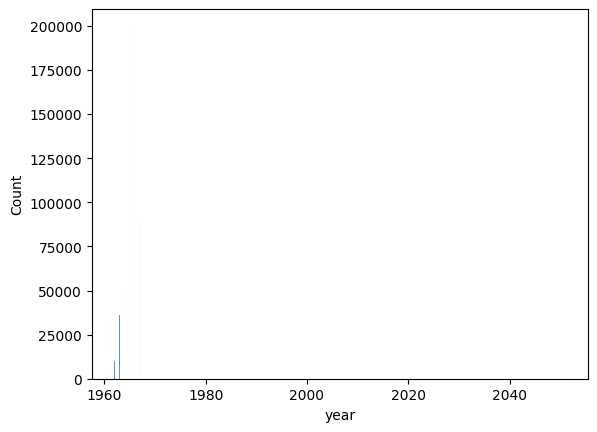

In [29]:
df_num = df_num.copy(deep=True)
df_num['year'] = df_num['year_1'] + 1962
df_num['year'] = df_num['year'].astype('float')
sns.histplot(data=df_num, x='year')

In [30]:
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x<1962 else x)
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x>1980 else x)
df_num[['year', 'year_1']].sample(10)

,year,year_1
209983,1965.0,3.0
210173,1965.0,3.0
429833,1966.0,4.0
344605,1965.0,3.0
550048,1967.0,5.0
720716,1965.0,3.0
427299,1966.0,4.0
213887,1964.0,2.0
646047,1966.0,4.0
282995,1965.0,3.0


day:

<Axes: xlabel='day_1', ylabel='Count'>

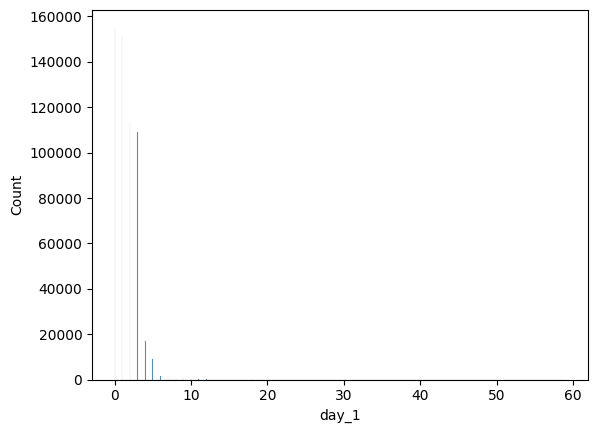

In [31]:
df_num['day_1'] = df_num['day_1'].astype(int)
sns.histplot(data=df_num, x='day_1')

In [32]:
df_num['day_1'] = df_num['day_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_2', ylabel='Count'>

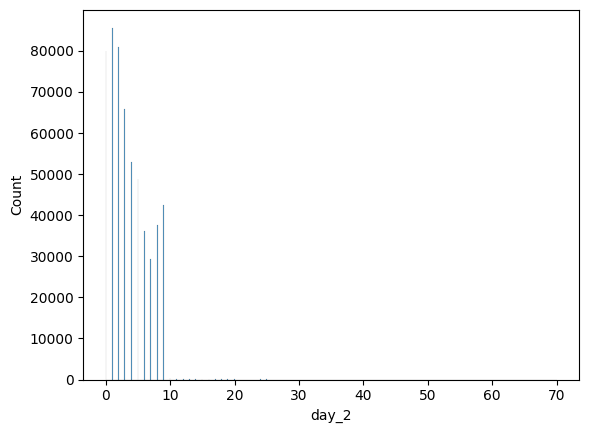

In [33]:
df_num['day_2'] = df_num['day_2'].astype(int)
sns.histplot(data=df_num, x='day_2')

In [34]:
df_num['day_2'] = df_num['day_2'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_3', ylabel='Count'>

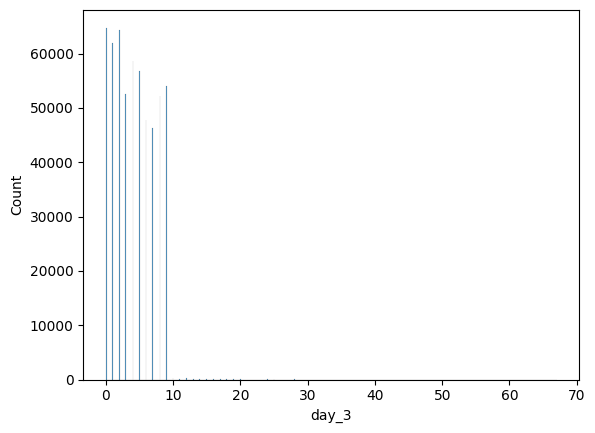

In [35]:
df_num['day_3'] = df_num['day_3'].astype(int)
sns.histplot(data=df_num, x='day_3')

In [36]:
df_num['day_3'] = df_num['day_3'].apply(lambda x: np.nan if x>9 else x)

In [37]:
df_num_daycheck = df_num[~pd.isna(df_num['day_1'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_2'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_3'])]
df_num_daycheck['day_of_year'] = df_num_daycheck['day_1'].astype(int).astype(str) + df_num_daycheck['day_2'].astype(int).astype(str) + df_num_daycheck['day_3'].astype(int).astype(str)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].astype(int)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_num_nullday = df_num.loc[pd.isna(df_num['day_1']) | pd.isna(df_num['day_2']) | pd.isna(df_num['day_3'])]
df_num_nullday = df_num_nullday.copy(deep=True)
df_num_nullday['day_of_year'] = np.nan
df_num = pd.concat([df_num_daycheck, df_num_nullday])
print(len(df_num))
df_num[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

561252


,day_of_year,day_1,day_2,day_3
714853,220.0,2.0,2.0,0.0
783083,110.0,1.0,1.0,0.0
617470,366.0,3.0,6.0,6.0
303052,NaN,6.0,0.0,1.0
375639,297.0,2.0,9.0,7.0
787413,37.0,0.0,3.0,7.0
607763,146.0,1.0,4.0,6.0
719785,340.0,3.0,4.0,0.0
437980,340.0,3.0,4.0,0.0
262011,284.0,2.0,8.0,4.0


hour:

<Axes: xlabel='hour_1', ylabel='Count'>

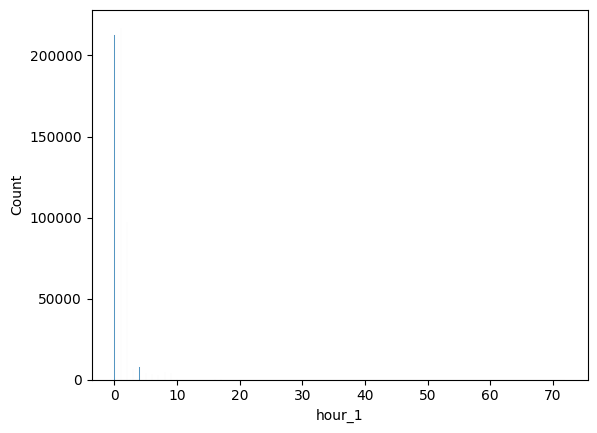

In [38]:
df_num['hour_1'] = df_num['hour_1'].astype(int)
sns.histplot(data=df_num, x='hour_1')

In [39]:
df_num['hour_1'] = df_num['hour_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='hour_2', ylabel='Count'>

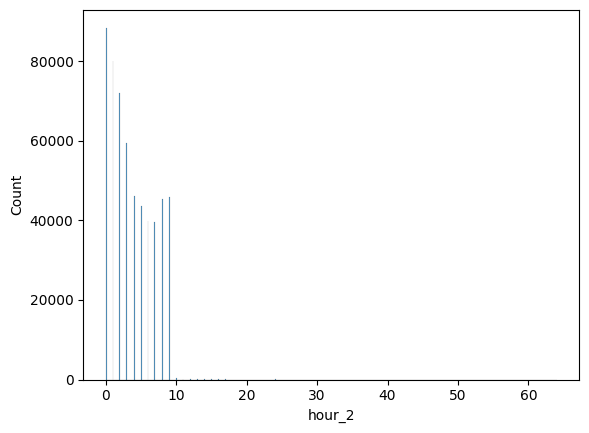

In [40]:
df_num['hour_2'] = df_num['hour_2'].astype(int)
sns.histplot(data=df_num, x='hour_2')

In [41]:
df_num['hour_2'] = df_num['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [42]:
df_num_hourcheck = df_num[~pd.isna(df_num['hour_1'])]
df_num_hourcheck = df_num_hourcheck[~pd.isna(df_num_hourcheck['hour_2'])]
df_num_hourcheck['hour'] = df_num_hourcheck['hour_1'].astype(int).astype(str) + df_num_hourcheck['hour_2'].astype(int).astype(str)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].astype(int)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_num_nullhour = df_num.loc[pd.isna(df_num['hour_1']) | pd.isna(df_num['hour_2'])]
df_num_nullhour = df_num_nullhour.copy(deep=True)
df_num_nullhour['hour'] = np.nan
df_num = pd.concat([df_num_hourcheck, df_num_nullhour])
print(len(df_num))
df_num[['hour', 'hour_1', 'hour_2']].sample(10)

561252


,hour,hour_1,hour_2
267476,19.0,1.0,9.0
394761,15.0,1.0,5.0
14835,22.0,2.0,2.0
603855,3.0,0.0,3.0
274890,4.0,0.0,4.0
596237,9.0,0.0,9.0
669107,NaN,3.0,0.0
448701,9.0,0.0,9.0
764717,15.0,1.0,5.0
753265,9.0,0.0,9.0


minute:

<Axes: xlabel='minute_1', ylabel='Count'>

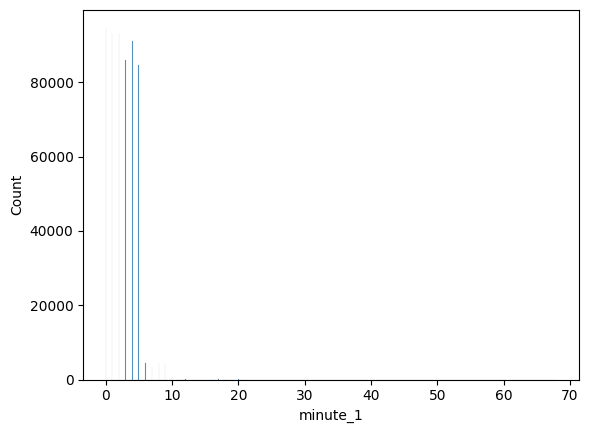

In [43]:
df_num['minute_1'] = df_num['minute_1'].astype(int)
sns.histplot(data=df_num, x='minute_1')

In [44]:
df_num['minute_1'] = df_num['minute_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='minute_2', ylabel='Count'>

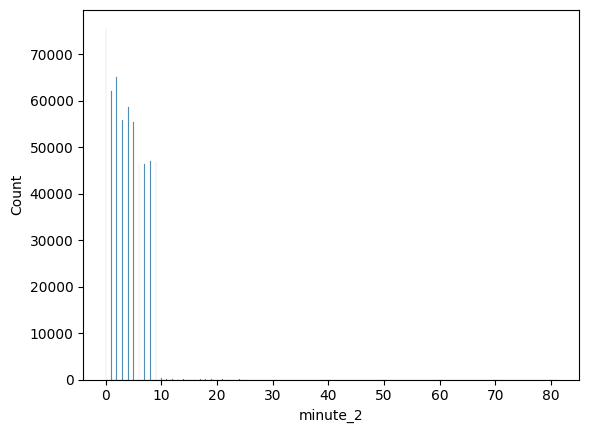

In [45]:
df_num['minute_2'] = df_num['minute_2'].astype(int)
sns.histplot(data=df_num, x='minute_2')

In [46]:
df_num['minute_2'] = df_num['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [47]:
df_num_mincheck = df_num[~pd.isna(df_num['minute_1'])]
df_num_mincheck = df_num_mincheck[~pd.isna(df_num_mincheck['minute_2'])]
df_num_mincheck['minute'] = df_num_mincheck['minute_1'].astype(int).astype(str) + df_num_mincheck['minute_2'].astype(int).astype(str)
df_num_mincheck['minute'] = df_num_mincheck['minute'].astype(int)
df_num_mincheck['minute'] = df_num_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_num_nullmin = df_num.loc[pd.isna(df_num['minute_1']) | pd.isna(df_num['minute_2'])]
df_num_nullmin = df_num_nullmin.copy(deep=True)
df_num_nullmin['minute'] = np.nan
df_num = pd.concat([df_num_mincheck, df_num_nullmin])
print(len(df_num))
df_num[['minute', 'minute_1', 'minute_2']].sample(10)

561252


,minute,minute_1,minute_2
457831,26.0,2.0,6.0
388314,36.0,3.0,6.0
316385,47.0,4.0,7.0
749389,45.0,4.0,5.0
400434,29.0,2.0,9.0
838809,48.0,4.0,8.0
745592,25.0,2.0,5.0
377342,39.0,3.0,9.0
719506,5.0,0.0,5.0
216671,57.0,5.0,7.0


second:

<Axes: xlabel='second_1', ylabel='Count'>

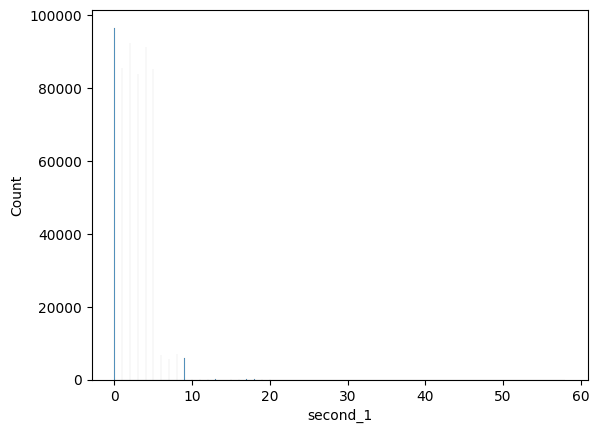

In [48]:
df_num['second_1'] = df_num['second_1'].astype(int)
sns.histplot(data=df_num, x='second_1')

In [49]:
df_num['second_1'] = df_num['second_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='second_2', ylabel='Count'>

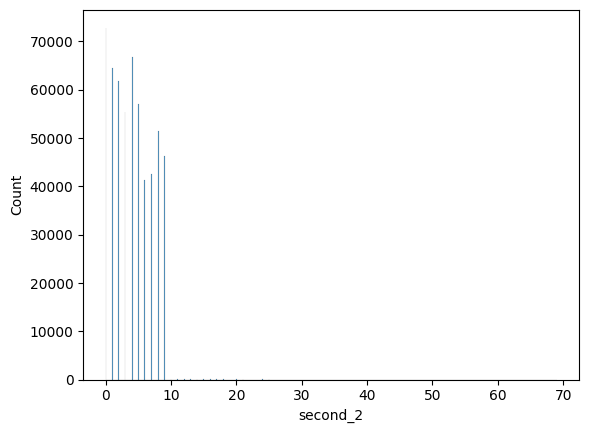

In [50]:
df_num['second_2'] = df_num['second_2'].astype(int)
sns.histplot(data=df_num, x='second_2')

In [51]:
df_num['second_2'] = df_num['second_2'].apply(lambda x: np.nan if x>9 else x)

In [52]:
df_num_seccheck = df_num[~pd.isna(df_num['second_1'])]
df_num_seccheck = df_num_seccheck[~pd.isna(df_num_seccheck['second_2'])]
df_num_seccheck['second'] = df_num_seccheck['second_1'].astype(int).astype(str) + df_num_seccheck['second_2'].astype(int).astype(str)
df_num_seccheck['second'] = df_num_seccheck['second'].astype(int)
df_num_seccheck['second'] = df_num_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_num_nullsec = df_num.loc[pd.isna(df_num['second_1']) | pd.isna(df_num['second_2'])]
df_num_nullsec = df_num_nullsec.copy(deep=True)
df_num_nullsec['second'] = np.nan
df_num = pd.concat([df_num_seccheck, df_num_nullsec])
print(len(df_num))
df_num[['second', 'second_1', 'second_2']].sample(10)

561252


,second,second_1,second_2
123806,24.0,2.0,4.0
387409,NaN,8.0,5.0
630953,2.0,0.0,2.0
429866,55.0,5.0,5.0
461295,1.0,0.0,1.0
296589,4.0,0.0,4.0
74535,22.0,2.0,2.0
482127,37.0,3.0,7.0
437325,48.0,4.0,8.0
322734,40.0,4.0,0.0


construct timestamp:

In [53]:
df_num = construct_timestamp(df_in=df_num)
print(len(df_num))

561252


In [54]:
df_num[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
196180,1962.0,05,30,NaN,42.0,50.0,1962-05-30 00:00:00,4
224303,1965.0,07,30,10.0,59.0,44.0,1965-07-30 10:59:44,1
395367,1966.0,07,20,4.0,19.0,3.0,1966-07-20 04:19:03,1
440361,1967.0,NaN,NaN,19.0,15.0,17.0,NaT,0
134948,1964.0,01,13,NaN,44.0,4.0,1964-01-13 00:00:00,4
343043,1965.0,01,24,1.0,4.0,18.0,1965-01-24 01:04:18,1
783432,1965.0,01,15,15.0,18.0,6.0,1965-01-15 15:18:06,1
832318,1965.0,05,30,0.0,45.0,14.0,1965-05-30 00:45:14,1
606980,1967.0,05,21,17.0,5.0,35.0,1967-05-21 17:05:35,1
622291,1966.0,01,12,15.0,19.0,48.0,1966-01-12 15:19:48,1


#  

#### dot - check timestamp components, construct timestamp:

In [55]:
df_dot = df_dot.copy(deep=True)
df_dot[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'is_dot']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2,is_dot
239556,NaN,0.0,0.0,10.0,8.0,0.0,0.0,12.0,9.0,0.0,NaN
335521,NaN,0.0,2.0,1.0,7.0,0.0,3.0,1.0,3.0,5.0,NaN
174977,NaN,6.0,1.0,1.0,2.0,2.0,5.0,2.0,4.0,5.0,NaN
795191,NaN,16.0,4.0,8.0,8.0,1.0,8.0,9.0,8.0,10.0,NaN
794193,NaN,4.0,8.0,8.0,8.0,0.0,1.0,2.0,0.0,0.0,NaN
807619,NaN,8.0,10.0,0.0,0.0,10.0,12.0,12.0,12.0,4.0,NaN
801865,NaN,10.0,10.0,8.0,14.0,4.0,9.0,0.0,10.0,1.0,NaN
176816,NaN,16.0,12.0,4.0,8.0,1.0,8.0,16.0,10.0,18.0,NaN
815840,NaN,2.0,14.0,0.0,8.0,2.0,8.0,0.0,9.0,5.0,NaN
805185,NaN,8.0,8.0,0.0,8.0,0.0,12.0,0.0,8.0,1.0,NaN


day:

<Axes: xlabel='day_1', ylabel='Count'>

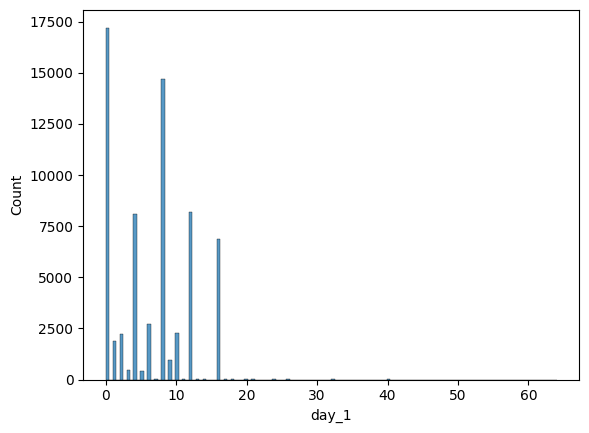

In [56]:
df_dot['day_1'] = df_dot['day_1'].astype(int)
sns.histplot(data=df_dot, x='day_1')

In [57]:
df_dot['day_1'] = df_dot['day_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_2', ylabel='Count'>

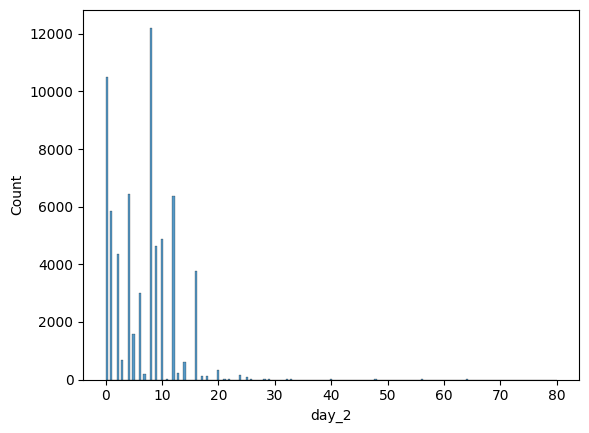

In [58]:
df_dot['day_2'] = df_dot['day_2'].astype(int)
sns.histplot(data=df_dot, x='day_2')

In [59]:
df_dot['day_2'] = df_dot['day_2'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_3', ylabel='Count'>

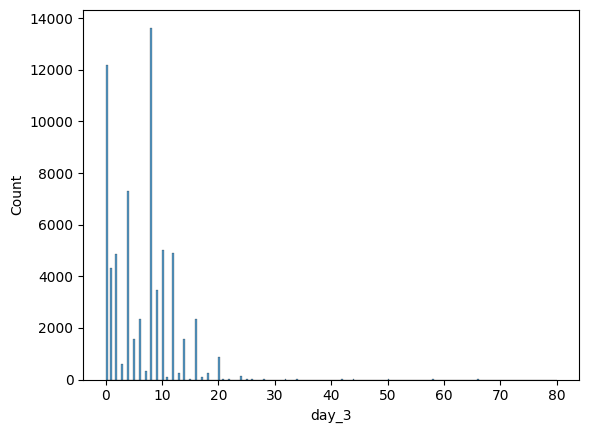

In [60]:
df_dot['day_3'] = df_dot['day_3'].astype(int)
sns.histplot(data=df_dot, x='day_3')

In [61]:
df_dot['day_3'] = df_dot['day_3'].apply(lambda x: np.nan if x>9 else x)

In [62]:
df_dot_daycheck = df_dot[~pd.isna(df_dot['day_1'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_2'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_3'])]
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_1'].astype(int).astype(str) + df_dot_daycheck['day_2'].astype(int).astype(str) + df_dot_daycheck['day_3'].astype(int).astype(str)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].astype(int)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_dot_nullday = df_dot.loc[pd.isna(df_dot['day_1']) | pd.isna(df_dot['day_2']) | pd.isna(df_dot['day_3'])]
df_dot_nullday = df_dot_nullday.copy(deep=True)
df_dot_nullday['day_of_year'] = np.nan
df_dot = pd.concat([df_dot_daycheck, df_dot_nullday])
print(len(df_dot))
df_dot[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

66282


,day_of_year,day_1,day_2,day_3
325154,NaN,NaN,9.0,8.0
328617,NaN,NaN,0.0,6.0
799436,284.0,2.0,8.0,4.0
191878,255.0,2.0,5.0,5.0
332946,NaN,NaN,8.0,1.0
337400,NaN,6.0,5.0,2.0
339031,NaN,NaN,NaN,9.0
195975,60.0,0.0,6.0,0.0
334274,NaN,NaN,2.0,NaN
248150,NaN,0.0,NaN,NaN


year - infer from day:

In [63]:
df_dot['year'] = np.nan
for i in range(0, len(df_dot)):
    day = df_dot['day_of_year'].iloc[i]
    if (day < 366) & (day > 0):
        if day > 271:
            df_dot['year'].iloc[i] = 1962
        else:
            df_dot['year'].iloc[i] = 1963
df_dot[['year', 'day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_15572\2722169012.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dot['year'].iloc[i] = 1963
C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_15572\2722169012.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dot['year'].iloc[i] = 1962


,year,day_of_year,day_1,day_2,day_3
344087,NaN,NaN,NaN,8.0,0.0
330042,1963.0,41.0,0.0,4.0,1.0
174453,NaN,NaN,NaN,2.0,NaN
179103,NaN,NaN,4.0,0.0,1.0
796179,NaN,NaN,0.0,NaN,NaN
793743,NaN,NaN,8.0,4.0,2.0
805533,NaN,NaN,8.0,2.0,0.0
183376,NaN,NaN,NaN,8.0,6.0
243755,NaN,NaN,NaN,8.0,5.0
237831,NaN,NaN,0.0,1.0,NaN


hour:

<Axes: xlabel='hour_1', ylabel='Count'>

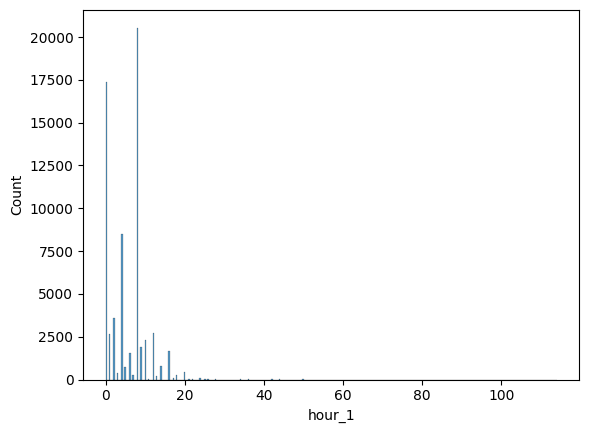

In [64]:
df_dot['hour_1'] = df_dot['hour_1'].astype(int)
sns.histplot(data=df_dot, x='hour_1')

In [65]:
df_dot['hour_1'] = df_dot['hour_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='hour_2', ylabel='Count'>

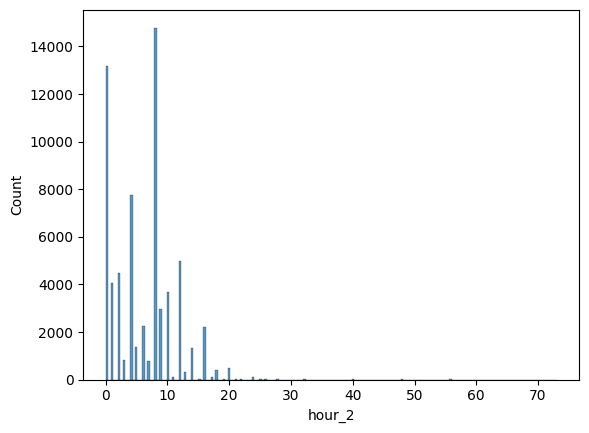

In [66]:
df_dot['hour_2'] = df_dot['hour_2'].astype(int)
sns.histplot(data=df_dot, x='hour_2')

In [67]:
df_dot['hour_2'] = df_dot['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [68]:
df_dot_hourcheck = df_dot[~pd.isna(df_dot['hour_1'])]
df_dot_hourcheck = df_dot_hourcheck[~pd.isna(df_dot_hourcheck['hour_2'])]
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour_1'].astype(int).astype(str) + df_dot_hourcheck['hour_2'].astype(int).astype(str)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].astype(int)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_dot_nullhour = df_dot.loc[pd.isna(df_dot['hour_1']) | pd.isna(df_dot['hour_2'])]
df_dot_nullhour = df_dot_nullhour.copy(deep=True)
df_dot_nullhour['hour'] = np.nan
df_dot = pd.concat([df_dot_hourcheck, df_dot_nullhour])
print(len(df_dot))
df_dot[['hour', 'hour_1', 'hour_2']].sample(10)

66282


,hour,hour_1,hour_2
329147,8.0,0.0,8.0
815185,8.0,0.0,8.0
327195,NaN,8.0,0.0
328014,NaN,4.0,4.0
337578,NaN,8.0,2.0
802261,NaN,8.0,6.0
329043,NaN,8.0,4.0
247190,NaN,NaN,0.0
795722,NaN,NaN,6.0
204105,NaN,8.0,NaN


minute:

<Axes: xlabel='minute_1', ylabel='Count'>

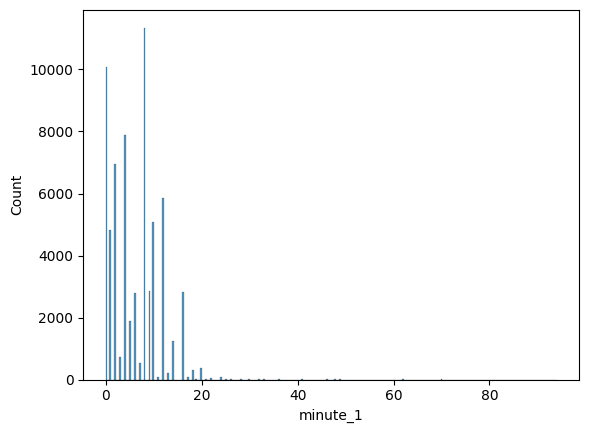

In [69]:
df_dot['minute_1'] = df_dot['minute_1'].astype(int)
sns.histplot(data=df_dot, x='minute_1')

In [70]:
df_dot['minute_1'] = df_dot['minute_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='minute_2', ylabel='Count'>

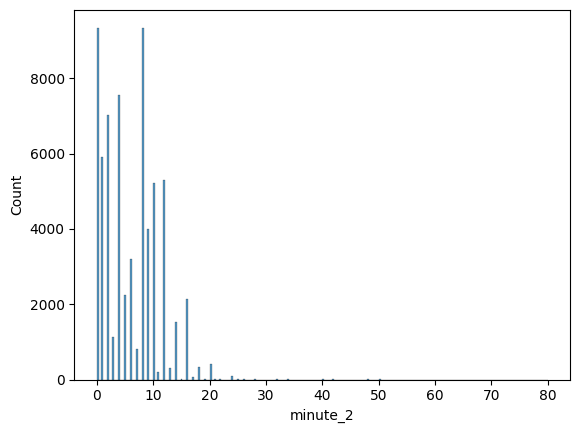

In [71]:
df_dot['minute_2'] = df_dot['minute_2'].astype(int)
sns.histplot(data=df_dot, x='minute_2')

In [72]:
df_dot['minute_2'] = df_dot['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [73]:
df_dot_mincheck = df_dot[~pd.isna(df_dot['minute_1'])]
df_dot_mincheck = df_dot_mincheck[~pd.isna(df_dot_mincheck['minute_2'])]
df_dot_mincheck['minute'] = df_dot_mincheck['minute_1'].astype(int).astype(str) + df_dot_mincheck['minute_2'].astype(int).astype(str)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].astype(int)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullmin = df_dot.loc[pd.isna(df_dot['minute_1']) | pd.isna(df_dot['minute_2'])]
df_dot_nullmin = df_dot_nullmin.copy(deep=True)
df_dot_nullmin['minute'] = np.nan
df_dot = pd.concat([df_dot_mincheck, df_dot_nullmin])
print(len(df_dot))
df_dot[['minute', 'minute_1', 'minute_2']].sample(10)

66282


,minute,minute_1,minute_2
820511,NaN,NaN,4.0
337989,1.0,0.0,1.0
181853,NaN,6.0,7.0
178287,54.0,5.0,4.0
236069,NaN,9.0,0.0
252841,22.0,2.0,2.0
196525,40.0,4.0,0.0
338506,NaN,8.0,NaN
324851,23.0,2.0,3.0
820704,NaN,NaN,NaN


second:

<Axes: xlabel='second_1', ylabel='Count'>

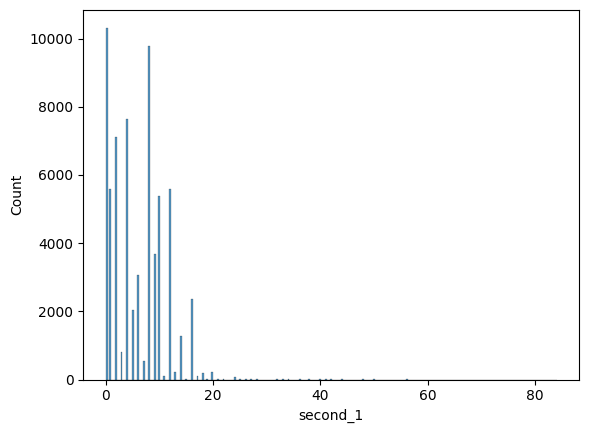

In [74]:
df_dot['second_1'] = df_dot['second_1'].astype(int)
sns.histplot(data=df_dot, x='second_1')

In [75]:
df_dot['second_1'] = df_dot['second_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='second_2', ylabel='Count'>

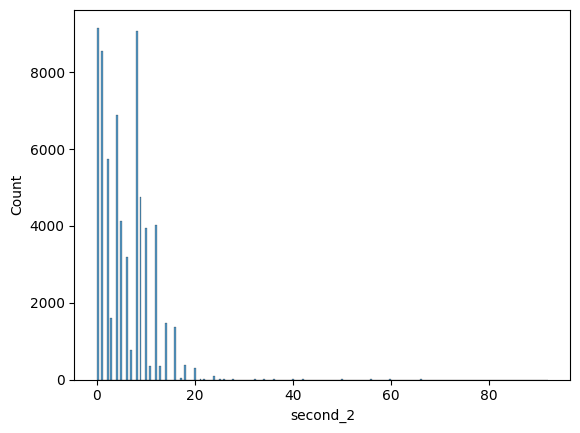

In [76]:
df_dot['second_2'] = df_dot['second_2'].astype(int)
sns.histplot(data=df_dot, x='second_2')

In [77]:
df_dot['second_2'] = df_dot['second_2'].apply(lambda x: np.nan if x>9 else x)

In [78]:
df_dot_seccheck = df_dot[~pd.isna(df_dot['second_1'])]
df_dot_seccheck = df_dot_seccheck[~pd.isna(df_dot_seccheck['second_2'])]
df_dot_seccheck['second'] = df_dot_seccheck['second_1'].astype(int).astype(str) + df_dot_seccheck['second_2'].astype(int).astype(str)
df_dot_seccheck['second'] = df_dot_seccheck['second'].astype(int)
df_dot_seccheck['second'] = df_dot_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullsec = df_dot.loc[pd.isna(df_dot['second_1']) | pd.isna(df_dot['second_2'])]
df_dot_nullsec = df_dot_nullsec.copy(deep=True)
df_dot_nullsec['second'] = np.nan
df_dot = pd.concat([df_dot_seccheck, df_dot_nullsec])
print(len(df_dot))
df_dot[['second', 'second_1', 'second_2']].sample(10)

66282


,second,second_1,second_2
820325,NaN,2.0,NaN
809393,34.0,3.0,4.0
810236,NaN,NaN,4.0
327088,46.0,4.0,6.0
189219,NaN,8.0,9.0
204122,NaN,NaN,8.0
340708,NaN,0.0,NaN
816539,25.0,2.0,5.0
806983,6.0,0.0,6.0
325821,1.0,0.0,1.0


construct timestamp:

In [79]:
df_dot = construct_timestamp(df_in=df_dot)
print(len(df_dot))

66282


In [80]:
df_dot[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
809415,1963.0,03,01,NaN,45.0,24.0,1963-03-01 00:00:00,4
813309,NaN,NaN,NaN,NaN,NaN,2.0,NaT,0
797005,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
819432,1963.0,03,29,NaN,NaN,NaN,1963-03-29 00:00:00,4
810285,NaN,NaN,NaN,20.0,19.0,NaN,NaT,0
324671,1963.0,02,14,0.0,36.0,NaN,1963-02-14 00:36:00,2
808279,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
804502,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
337174,NaN,NaN,NaN,NaN,52.0,23.0,NaT,0
803435,NaN,NaN,NaN,8.0,2.0,26.0,NaT,0


#  

#### Check station number:

num2:

<Axes: xlabel='station_number_OCR', ylabel='Count'>

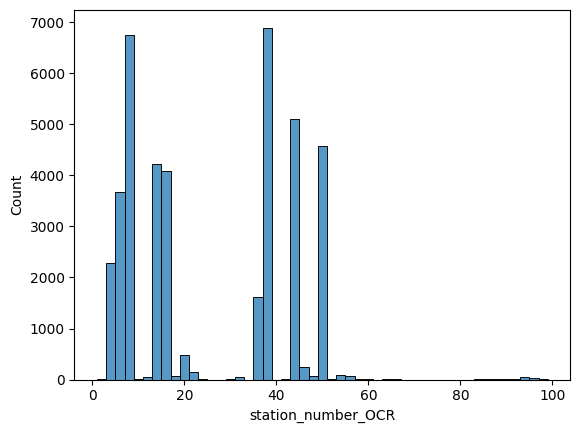

In [81]:
df_num2['station_number_OCR'] = df_num2['station_number_OCR'].astype('float')
sns.histplot(data=df_num2, x='station_number_OCR')

In [82]:
df_num2['station_number'] = df_num2['station_number_OCR']
df_num2[['station_number', 'station_number_OCR']].sample(10)

,station_number,station_number_OCR
46385,38.0,38.0
48736,38.0,38.0
23095,13.0,13.0
99565,15.0,15.0
74856,14.0,14.0
78136,14.0,14.0
101545,8.0,8.0
17223,38.0,38.0
36403,15.0,15.0
124600,8.0,8.0


num:

<Axes: xlabel='station_number_1', ylabel='Count'>

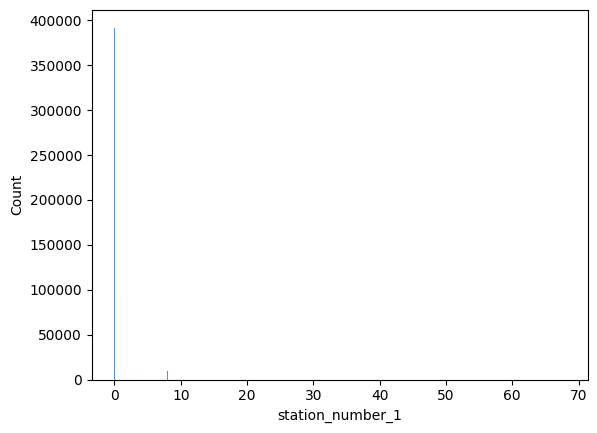

In [83]:
df_num['station_number_1'] = df_num['station_number_1'].astype(int)
sns.histplot(data=df_num, x='station_number_1')

In [84]:
df_num['station_number_1'] = df_num['station_number_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='station_number_2', ylabel='Count'>

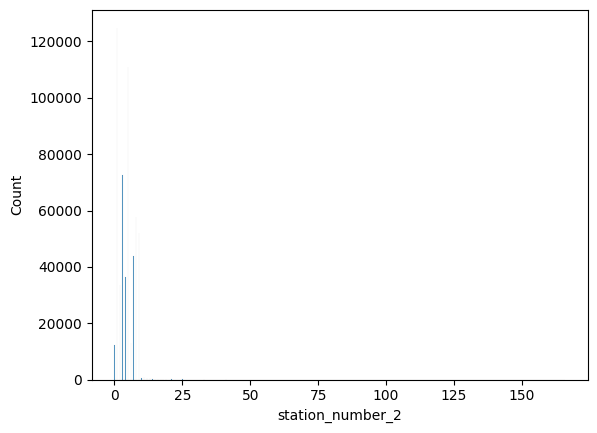

In [85]:
df_num['station_number_2'] = df_num['station_number_2'].astype(int)
sns.histplot(data=df_num, x='station_number_2')

In [86]:
df_num['station_number_2'] = df_num['station_number_2'].apply(lambda x: np.nan if x>9 else x)

In [87]:
df_num_stncheck = df_num[~pd.isna(df_num['station_number_1'])]
df_num_stncheck = df_num_stncheck[~pd.isna(df_num_stncheck['station_number_2'])]
df_num_stncheck['station_number'] = df_num_stncheck['station_number_1'].astype(int).astype(str) + df_num_stncheck['station_number_2'].astype(int).astype(str)
df_num_stncheck['station_number'] = df_num_stncheck['station_number'].astype(int)
df_num_nullstn = df_num.loc[pd.isna(df_num['station_number_1']) | pd.isna(df_num['station_number_2'])]
df_num_nullstn = df_num_nullstn.copy(deep=True)
df_num_nullstn['station_number'] = np.nan
df_num = pd.concat([df_num_stncheck, df_num_nullstn])
print(len(df_num))
df_num[['station_number', 'station_number_1', 'station_number_2']].sample(10)

561252


,station_number,station_number_1,station_number_2
657646,18.0,1.0,8.0
244878,9.0,0.0,9.0
518831,2.0,0.0,2.0
787673,2.0,0.0,2.0
555223,8.0,0.0,8.0
650992,4.0,0.0,4.0
485214,9.0,0.0,9.0
688489,1.0,0.0,1.0
650256,4.0,0.0,4.0
780552,12.0,1.0,2.0


dot:

In [88]:
df_dot[['station_number']].sample(10)

,station_number
176300,9.0
803551,7.0
341179,0.0
790667,1.0
254374,10.0
812622,5.0
806703,1.0
239500,0.0
242128,10.0
800618,0.0


#  

#### Recombine results, save:

In [89]:
df_result2 = pd.concat([df_num2, df_num, df_dot, df_outlier, df_loss])
print(len(df_result2))
df_result2.sample(10)

840652


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,year,day_of_year,hour,minute,second,time_quality,month_day,month,day,Timestamp
286867,R014207938,919-A,99.png,num,1.661290,1042.000000,1.0,0.0,1.0,3.0,...,1965.0,159.0,12.0,5.0,2.0,1.0,06-08,06,08,1965-06-08 12:05:02
694519,R014207966,1205-5A,192.png,num,1.508065,1502.083333,5.0,0.0,5.0,3.0,...,1965.0,216.0,15.0,24.0,50.0,1.0,08-04,08,04,1965-08-04 15:24:50
51828,R014207821,3366-38A,186.png,loss,1.774194,1314.285714,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
775082,R014207975,1104-B,74.png,num,1.548387,1238.461538,12.0,1.0,2.0,3.0,...,1965.0,215.0,8.0,48.0,21.0,1.0,08-03,08,03,1965-08-03 08:48:21
792647,R014207978F,314,Image0353.png,dot,1.552419,278.571429,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,48.0,NaN,0.0,NaN,NaN,NaN,NaT
612284,R014207960,2566-8A,206.png,num,1.858871,92.452830,8.0,0.0,8.0,5.0,...,1967.0,55.0,19.0,30.0,57.0,1.0,02-24,02,24,1967-02-24 19:30:57
685780,R014207966,1178-B,8.png,num,1.625000,1252.830189,15.0,1.0,5.0,3.0,...,1965.0,155.0,2.0,7.0,30.0,1.0,06-04,06,04,1965-06-04 02:07:30
132360,R014207841,3103-8A,187.png,num2,1.721774,1352.941176,8.0,NaN,NaN,NaN,...,1965.0,284.0,14.0,2.0,22.0,1.0,10-11,10,11,1965-10-11 14:02:22
791689,R014207978F,312,Image0067.png,dot,1.500000,1064.285714,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaT
830222,R014207980,968-A,15.png,num,1.721774,168.627451,3.0,0.0,3.0,4.0,...,1966.0,12.0,2.0,48.0,40.0,1.0,01-12,01,12,1966-01-12 02:48:40


Save:

In [90]:
df_result2.to_csv(resultDir + 'result_postprocess_raw.csv', index=False)

#  

#### Retrieve station details:

In [91]:
df_stn_nums = pd.read_excel(logDir + 'station_number_changes.xlsx')
df_stn_nums.head()

,Station_Number,Station_Code,Station_Name,Start_Date,Notes
0,1,RES,"Resolute Bay, NT, Canada",1962-09-29,Assumed start date at launch.
1,1,BPT,"Blossom Point, MD, USA",1965-07-01,NaN
2,2,PRI,"Prince Albert, SK, Canada",1962-09-29,Assumed start date at launch.
3,3,OTT,"Ottawa, Canada",1962-09-29,Assumed start date at launch.
4,3,FTM,"Fort Myers, FL, USA",1965-07-01,NaN


In [92]:
change_dates = df_stn_nums['Start_Date'].drop_duplicates().sort_values().reset_index(drop=True)
stn_nums = df_stn_nums['Station_Number'].unique()

In [93]:
#df_result_pp = pd.read_csv(resultDir + 'result_postprocess_raw.csv')
df_result2 = df_result2.loc[~pd.isna(df_result2['station_number'])]

In [94]:
df_result3 = pd.DataFrame()
for i in range(0, len(change_dates)):
    #Before the first change date - Assume there are no station numbers before launch
    if i == 0:
        print(change_dates[i])
        df_part = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))
    
    elif i > 0:
        print(change_dates[i])
        df_part_ = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_part_ = df_part_.loc[df_part_['Timestamp'] >= change_dates[i-1]]
        
        df_sns = pd.DataFrame()
        for sn in stn_nums:
            df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
            df_sn = df_sn.loc[df_sn['Start_Date'] < change_dates[i]]
            if len(df_sn) > 1:
                df_sn = df_sn.sort_values('Start_Date', ascending=False)
                df_sn = df_sn.iloc[:1]
            df_sns = pd.concat([df_sns, df_sn])
        
        df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))

#After last change date
last_change_date = change_dates[len(change_dates)-1]
print('After ' + str(last_change_date))
df_part_ = df_result2.loc[df_result2['Timestamp'] > last_change_date]

df_sns = pd.DataFrame()
for sn in stn_nums:
    df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
    if len(df_sn) > 1:
        df_sn = df_sn.sort_values('Start_Date', ascending=False)
        df_sn = df_sn.iloc[:1]
    df_sns = pd.concat([df_sns, df_sn])

df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
df_result3 = pd.concat([df_result3, df_part])
print(len(df_result3))

1962-09-29 00:00:00
6050
1963-04-25 00:00:00
19569
1963-08-06 00:00:00
22866
1965-07-01 00:00:00
176268
After 1965-07-01 00:00:00
574875


In [95]:
df_stns = pd.read_csv(logDir + 'ground_stations.csv')
df_stns.head()

,Station_Code,Station_Name,Lat,Lng,Notes
0,ANT,"Antofagasta, Chile",23.6S,70.3W,NaN
1,BAT,"Byrd Station, Antarctica",80S,119.3W,Ref: https://en.wikipedia.org/wiki/Byrd_Station
2,BFR,"Bretigny, France",48.4N,2.2 E,Ref: https://en.wikipedia.org/wiki/Br%C3%A9tig...
3,BLR,"Boulder, CO, USA",40.1N,105.1W,NaN
4,BPT,"Blossom Point, MD, USA",38.4N,77.1W,NaN


In [96]:
df_result4 = df_result3.merge(df_stns[['Station_Code', 'Station_Name', 'Lat', 'Lng']], how='left', on='Station_Code')
print(len(df_result4))
df_result4[['Station_Number', 'Timestamp', 'Station_Code', 'Station_Name', 'Lat', 'Lng']].sample(10)

574875


,Station_Number,Timestamp,Station_Code,Station_Name,Lat,Lng
331226,1.0,1967-05-18 18:49:02,BPT,"Blossom Point, MD, USA",38.4N,77.1W
72335,5.0,1965-03-16 22:23:50,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
38799,5.0,1965-01-28 09:34:37,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
19695,20.0,1963-05-13 12:21:00,ROS,"Rosman, NC, USA",35.2N,82.9W
156925,9.0,1965-05-26 19:54:01,SOL,Falkland Islands (Islas Malvinas),51.8S,57.9W
475615,13.0,1966-04-27 01:48:08,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
105623,6.0,1964-10-01 15:28:14,FTM,"Fort Myers, FL, USA",26.6N,81.9W
168459,5.0,1965-04-30 00:00:00,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
490616,1.0,1965-11-08 17:06:58,BPT,"Blossom Point, MD, USA",38.4N,77.1W
181739,43.0,1966-01-17 05:16:03,RES,"Resolute Bay, NT, Canada",74.7N,95W


#  

#### Save Master:

In [97]:
df_result5 = df_result4[~pd.isna(df_result4['Station_Code'])]
df_result5 = df_result5[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 'Timestamp',
                         'time_quality', 'Station_Number', 'Station_Code', 'Station_Name', 'Lat', 'Lng']]
print(len(df_result5))
df_result5.sample(10)

524845


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,Timestamp,time_quality,Station_Number,Station_Code,Station_Name,Lat,Lng
393322,R014207958,2771-7B,328.png,num,1.500000,1837.500000,1967-01-20 01:21:14,1.0,7.0,QUI,"Quito, Ecuador",0.6S,78.6W
68590,R014207929F,463,Image0419.png,num,1.500000,1796.774194,1965-05-25 09:37:39,1.0,3.0,OTT,"Ottawa, Canada",45.4N,75.7W
462555,R014207964,1619-4A,260.png,num,1.681452,4821.428571,1966-02-01 08:40:02,1.0,4.0,NEW,"St. John's, NL, Canada",47.6N,52.4W
458852,R014207964,1605-1B,24.png,num,1.669355,1236.363636,1966-05-13 13:14:10,1.0,1.0,BPT,"Blossom Point, MD, USA",38.4N,77.1W
312961,R014207949,2138-5B,199.png,num,1.745968,1379.629630,1967-01-02 09:46:59,1.0,5.0,QUI,"Quito, Ecuador",0.6S,78.6W
272214,R014207946,1841-3A,274.png,num,1.564516,1456.603774,1966-09-01 18:39:38,1.0,3.0,FTM,"Fort Myers, FL, USA",26.6N,81.9W
475983,R014207965,1674-9B,49.png,num,1.524194,1266.037736,1966-01-26 12:23:36,1.0,9.0,SOL,Falkland Islands (Islas Malvinas),51.8S,57.9W
46600,R014207908F,582,Image0341.png,num,1.532258,1413.636364,1965-02-19 01:31:59,1.0,5.0,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
283390,R014207947,1891-12A,72.png,num,1.870968,1346.296296,1966-07-14 05:41:06,1.0,12.0,NEW,"St. John's, NL, Canada",47.6N,52.4W
180114,R014207816,3393-13A,208.png,num2,1.608871,1428.571429,1966-01-31 16:03:31,1.0,13.0,COL,"College, Fairbanks, AK, USA",64.9N,147.8W


In [98]:
df_result5 = df_result5.sort_values('Timestamp').reset_index(drop=True)
df_result5.to_csv(resultDir + 'result_master.csv', index=False)